In [100]:
# Import required libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns 
import requests
from datetime import datetime
import matplotlib.dates as mdates

# Preprocess CSV files
def preprocess_csv(file_path):
    df = pd.read_csv(file_path)
    df['year'] = pd.to_datetime(df['year'], format='%Y')  # Parse the 'year' column as datetime objects
    return df

co_df = preprocess_csv(r'C:\Users\Ken\Documents\Code Projects\Data_ML_Projects\MLProjectClimateResearch\ClimateResearchProject\Data\Pollution\AirPollutantCarbonMonoxide2ndMaximum8HourMean.csv')
pm25_df = preprocess_csv(r'C:\Users\Ken\Documents\Code Projects\Data_ML_Projects\MLProjectClimateResearch\ClimateResearchProject\Data\Pollution\AirPollutantParticulateMatterPM2.5.csv')
pm10_df = preprocess_csv(r'C:\Users\Ken\Documents\Code Projects\Data_ML_Projects\MLProjectClimateResearch\ClimateResearchProject\Data\Pollution\AirPollutantParticulateMatterPM10.csv')



# Merging dataframes
# Assuming all dataframes have a common 'Date' column
# and you want to combine them into a single dataframe for comparison purposes
combined_df = co_df.merge(pm25_df, on='year').merge(pm10_df, on='year')
combined_df['year'] = pd.to_datetime(combined_df['year'], format='%Y')  # Adjust format as needed
combined_df.set_index('year', inplace=True)

# Now, combined_df is ready for further analysis or visualization.




In [101]:
#preprocess data from API for PSI readings using JSON schema
# Function to fetch PSI data from the API
def fetch_psi_data(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

# Function to parse the fetched data
def parse_psi_data(json_data):
    # Flatten the nested JSON data into a dataframe
    readings = []
    for item in json_data['items']:
        for region, value in item['readings']['psi_twenty_four_hourly'].items():
            readings.append({
                'timestamp': item['timestamp'],
                'region': region,
                'psi_value': value
            })
    df = pd.DataFrame(readings)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

# Function to plot PSI data with formatted time labels
def plot_psi_data(df):
    # Check if the dataframe is empty
    if df.empty:
        print("The dataframe is empty. No data to plot.")
        return
    
    # Check if required columns are present
    if 'timestamp' not in df.columns or 'psi_value' not in df.columns:
        print("Required columns are missing from the dataframe.")
        return
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    regions = df['region'].unique()
    plt.figure(figsize=(15, 5))
    
    # Check that there are actually data points to plot
    if df['timestamp'].isnull().all() or df['psi_value'].isnull().all():
        print("Timestamp or PSI values are missing or null.")
        return
    
    for region in regions:
        region_df = df[df['region'] == region]
        if not region_df.empty:
            plt.plot(region_df['timestamp'], region_df['psi_value'], marker='o', label=region)
        else:
            print(f"No data for region: {region}")
            
    # Set x-axis major locator and formatter
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Ensure labels don't overlap
    plt.gcf().autofmt_xdate()
    
    plt.title(f'PSI Twenty Four Hourly Readings for {df["timestamp"].dt.date.unique()[0]}')
    plt.xlabel('Timestamp')
    plt.ylabel('PSI Value')
    plt.legend()
    plt.show()
    #key in the date required in the url when calling the function e.g. 2024-01-01



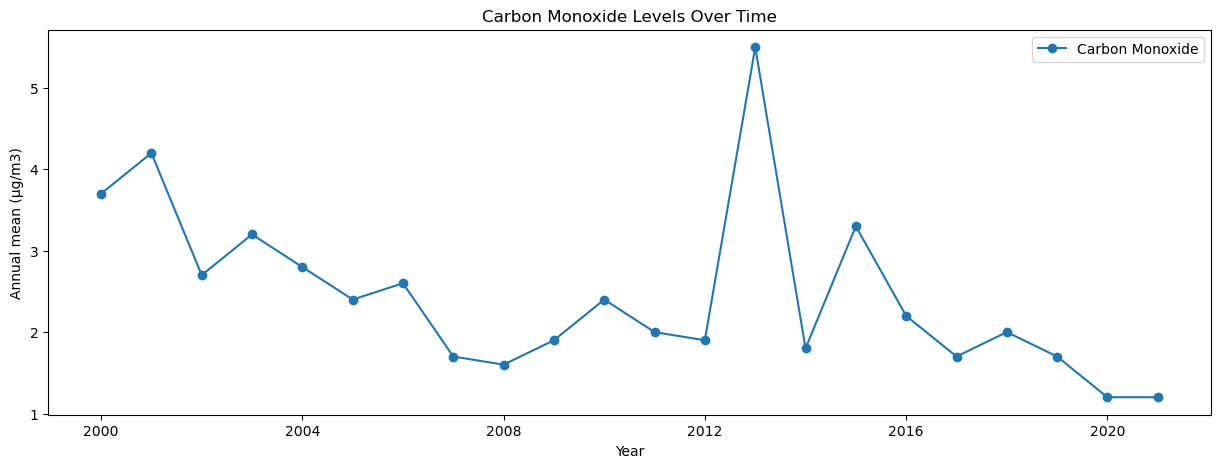

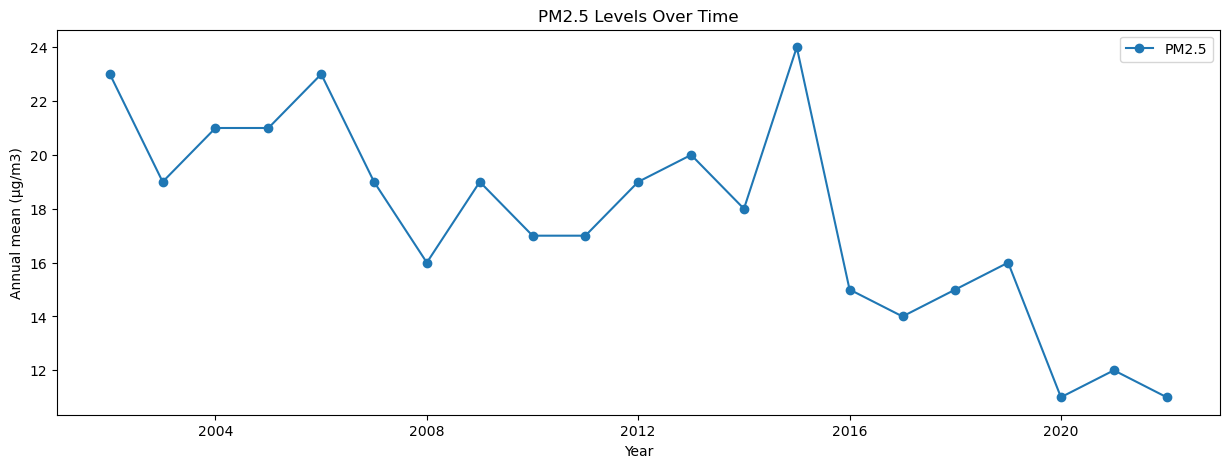

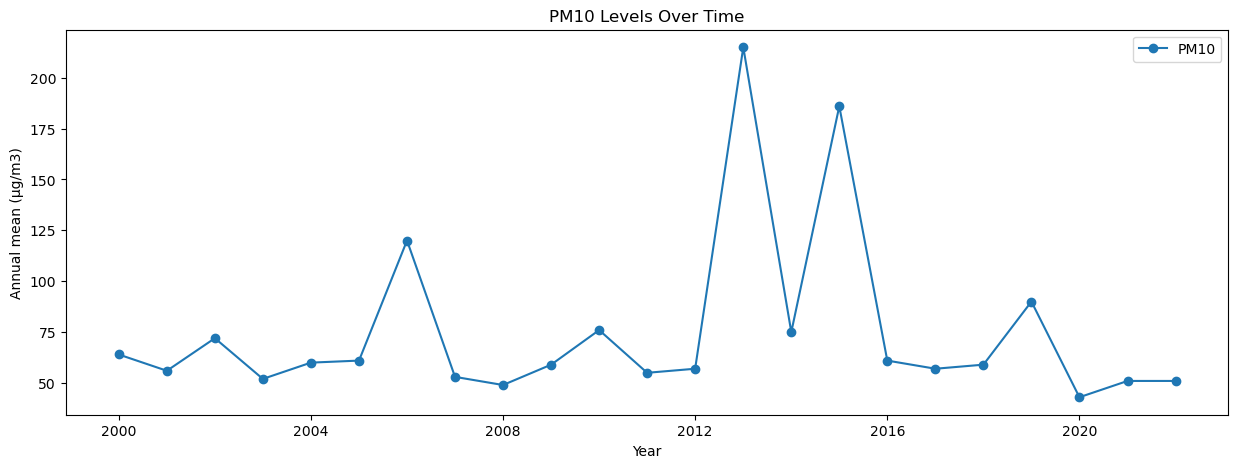

In [102]:

#function for visualizing time series plot for CO, PM2.5, and PM10 levels
# Assuming 'date' is a common column and has been parsed as datetime object, and
# 'value' column represents the pollutant value in each dataset
def plot_pollutant(df, pollutant_name, value_column_name):
    plt.figure(figsize=(15, 5))
    plt.plot(df['year'], df[value_column_name], marker='o', label=pollutant_name)
    plt.title(f'{pollutant_name} Levels Over Time')
    plt.xlabel('Year')
    plt.ylabel('Annual mean (µg/m3)')
    plt.legend()
    plt.show()

# Plot data for each pollutant
plot_pollutant(co_df, 'Carbon Monoxide', 'co_max_8hour_mean')
plot_pollutant(pm25_df, 'PM2.5', 'pm2.5_mean')
plot_pollutant(pm10_df, 'PM10', 'pm10_24hour_mean_99th_per')

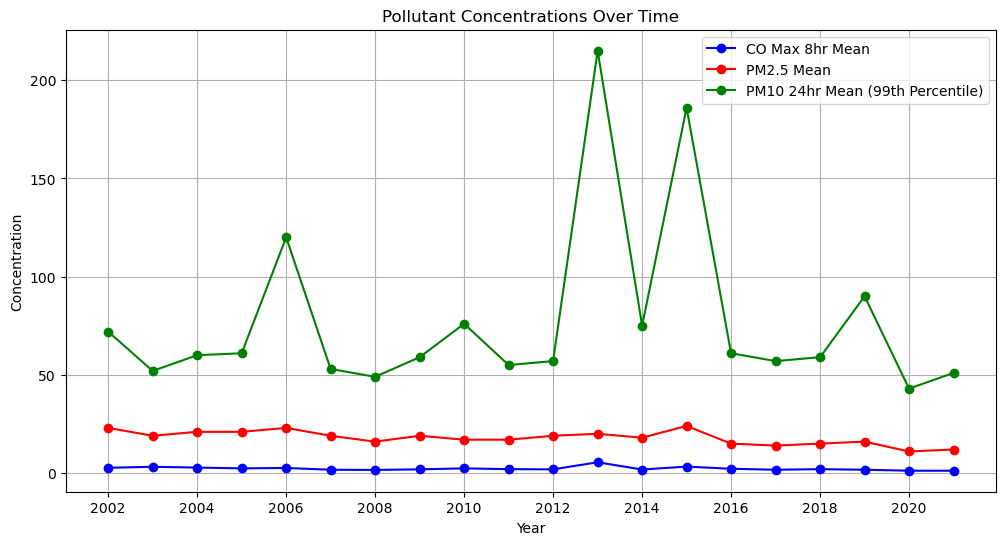

In [103]:
# Function to plot combined pollutant data for PM2.5,PM10 & CO levels
def plot_combined_pollutants(df):
    plt.figure(figsize=(12, 6))
    
    # Assuming 'year' is converted to datetime and set as index
    # Plot each pollutant with a different color and label
    plt.plot(df.index, df['co_max_8hour_mean'], marker='o', color='blue', label='CO Max 8hr Mean')
    plt.plot(df.index, df['pm2.5_mean'], marker='o', color='red', label='PM2.5 Mean')
    plt.plot(df.index, df['pm10_24hour_mean_99th_per'], marker='o', color='green', label='PM10 24hr Mean (99th Percentile)')
    
    # Adding labels and title
    plt.xlabel('Year')
    plt.ylabel('Concentration')
    plt.title('Pollutant Concentrations Over Time')
    
    # Add a legend
    plt.legend()
    
    # add grid for better readability
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Now call the function with the combined dataframe

plot_combined_pollutants(combined_df)


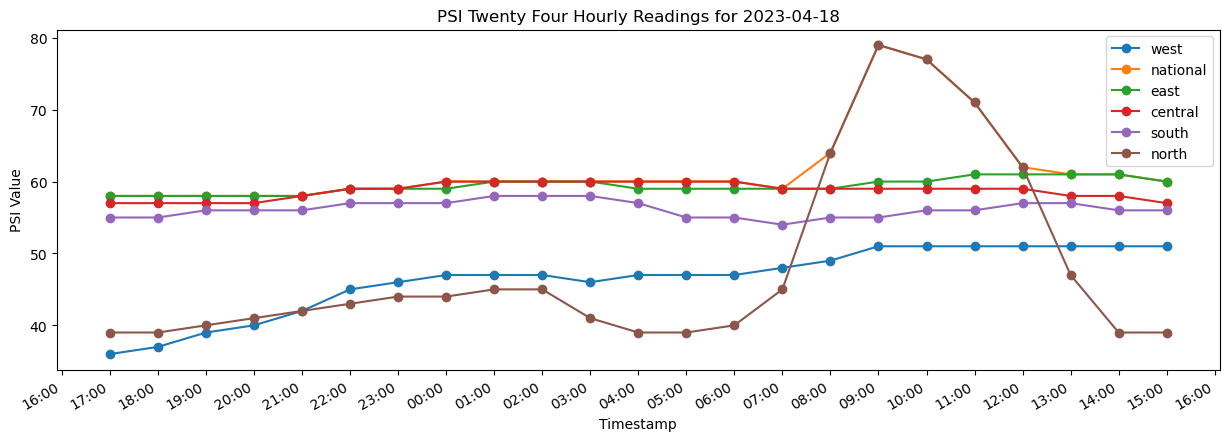

In [104]:
# Main flow invoking function to retrieve data from API 

api_url = "https://api.data.gov.sg/v1/environment/psi?date=2023-04-18"  #key in date that we wish to analyze
# Retrieve PSI data from the API
psi_data = fetch_psi_data(api_url)
# Extract relevant data for visualization
psi_df = parse_psi_data(psi_data)
# Plot the PSI data
plot_psi_data(psi_df)